In [1]:
import os
import numpy as np
import pandas as pd
from joblib import dump, load
import sys
import seaborn as sns
import json
sys.path.append(os.path.join(os.path.abspath('../'), 'predictions_collapsed'))
sys.path.append(os.path.join(os.path.abspath('../'), 'src'))
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
pd.set_option('display.max_colwidth', -1)
import glob

from config_loader import (
    D_CONFIG,
    DATASET_SITE_PATH, DATASET_SPLIT_PATH,
    DATASET_FEAT_PER_TSLICE_PATH,
    PROJECT_REPO_DIR, PROJECT_CONDA_ENV_YAML,
    RESULTS_SPLIT_PATH, RESULTS_FEAT_PER_TSTEP_PATH)

sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src'))
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src', 'rnn'))
from feature_transformation import *
from filter_admissions_by_tslice import get_preprocessed_data
from merge_features_all_tslices import merge_data_dicts, get_all_features_data
import matplotlib.pyplot as plt

<ipython-input-1-b8a0bc152174>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [26]:
DATASET_SITE_PATH

'/home/prash/datasets/v20200424/HIL'

In [3]:
labs_df, labs_data_dict, vitals_df, vitals_data_dict, \
    demographics_df, demographics_data_dict, outcomes_df, outcomes_data_dict = get_preprocessed_data(DATASET_SITE_PATH)

In [76]:
df_adt = pd.read_csv(
        os.path.join('/rgi/data/HUF/deidentified_data', 'ADT.txt'),
        delimiter='|')
service_code_dict = {'ANR' : 'Anesthesiology', 'CAR' : 'cardiology', 'CGD' : 'general_surgery_and_digestive',
                     'DER' : 'dermatology', 'DIG' : 'digestive_system', 'END' : 'endocrinology', 'HEM' : 'hematology',
                    'GIN' : 'gynaecology', 'MIR' : 'residents_interns', 'MIV' : 'internal_medicine', 
                    'MNU': 'neuclear_medicine', 'NFR' : 'Nephrology', 'NML' : 'lung', 'NRL' :'neurology',
                    'OBS': 'obstetrics', 'OFT':'opthalmology', 'ONC' : 'oncology', 'ORL' : 'ENT',
                    'REU':'rheumatology', 'URO': 'urology'}

## Plotting stay lengths by service ID

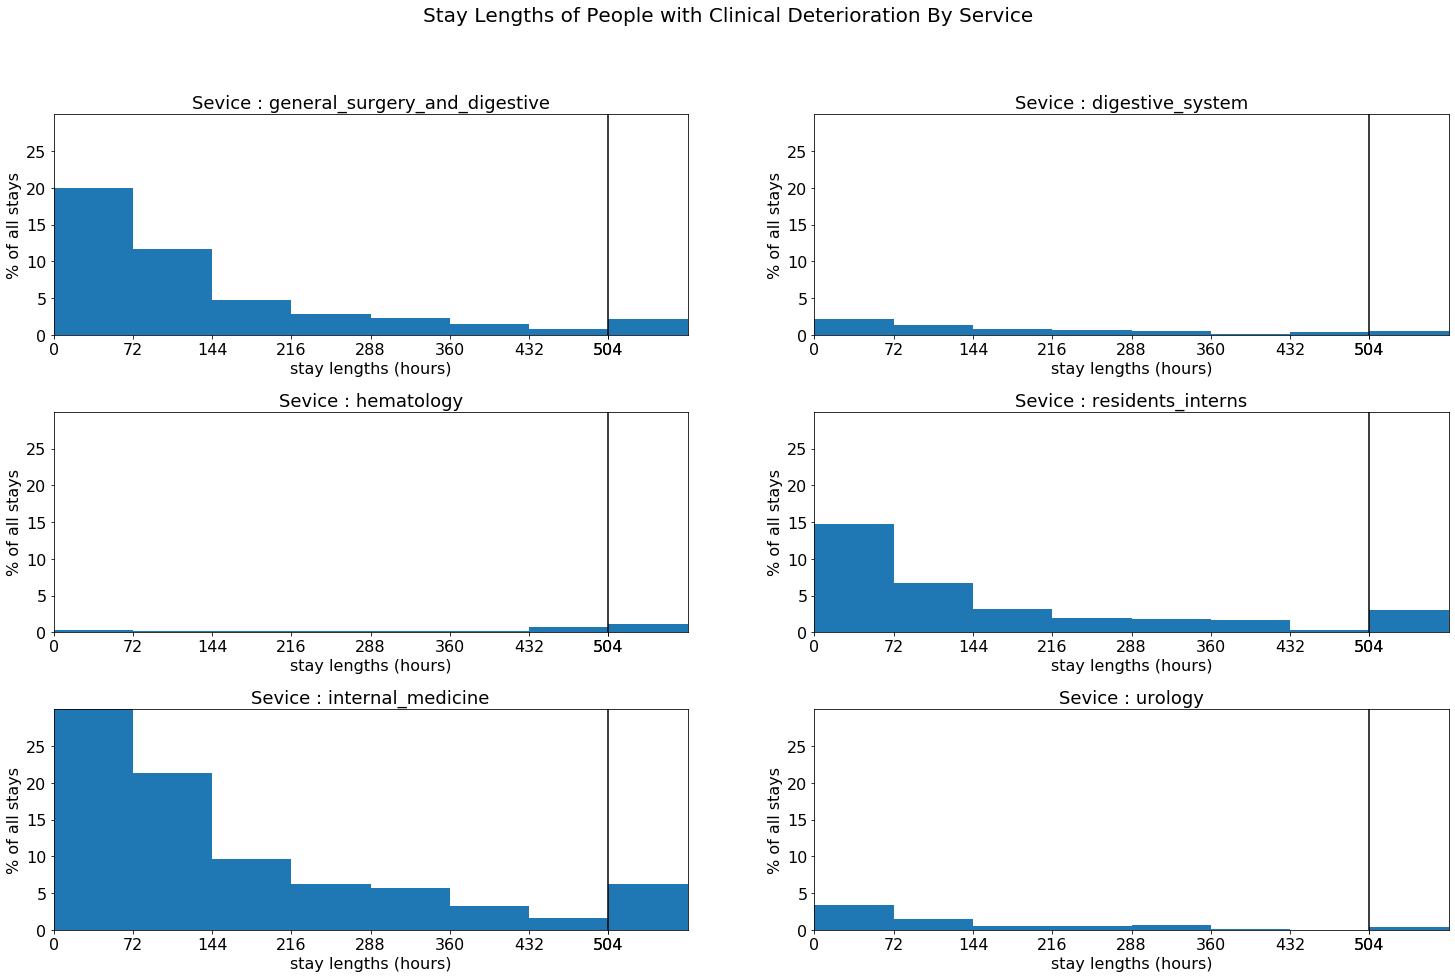

In [89]:
def get_stays_by_service_ids(service_code):
    curr_service_adms_df = df_adt[(df_adt.VALUE_TEXT==service_code) & 
                                  (df_adt.DESCRIPTION == 'service_start_ts')].drop_duplicates(subset='ADMISSION_ID').copy()
    curr_service_adms_df.rename(columns = { 'PATIENT_ID':'patient_id',
                                           'ADMISSION_ID':'hospital_admission_id',
                                           'FACILITY_CD':'facility_code'}, inplace=True)
    return curr_service_adms_df
    


key_cols  = ['patient_id', 'hospital_admission_id', 'facility_code']

# select services to plot
plot_service_list = ['CGD', 'DIG', 'HEM', 'MIR', 'MIV', 'URO']

f,axs =  plt.subplots(3,2, figsize=(25,15))
axs_list = [i for i in axs.reshape(-1,1)]
fontsize=16
for p, service in enumerate(plot_service_list):
    curr_ax = axs_list[p][0]
    df_transfer_to_icu_pos_outcomes = outcomes_df[outcomes_df.clinical_deterioration_outcome==1].copy()
    curr_service_adms_df = get_stays_by_service_ids(service)
    curr_service_stay_lengths = pd.merge(curr_service_adms_df, df_transfer_to_icu_pos_outcomes, 
                                         on=key_cols, how='inner')['stay_length']
    max_los = curr_service_stay_lengths.max()
    max_t = 504
    step=72
    bins = np.arange(0, max_t+1, step)
    if max_los > max_t+1:
        bins=np.insert(bins, len(bins), max_los)
    x = np.asarray(curr_service_stay_lengths)
    curr_ax.hist(x, bins=bins, weights=np.ones(len(x))*100 / len(df_transfer_to_icu_pos_outcomes))
#     curr_ax.hist(x, bins=bins)
    curr_ax.set_xlabel('stay lengths (hours)', fontsize=fontsize)
    curr_ax.set_ylabel('% of all stays', fontsize=fontsize)
    curr_ax.set_xlim([0, max_t+step])
    bins[-1]=max_t
    curr_ax.set_xticks(bins)
    ymin=0
    ymax=30
    curr_ax.vlines(max_t, ymin=ymin, ymax=ymax)
    curr_ax.set_ylim([ymin, ymax])
    curr_ax.set_yticks(np.arange(ymin, ymax, 5))
    curr_ax.set_title('Sevice : %s'%service_code_dict[service], fontsize=fontsize+2)

plt.subplots_adjust(hspace=0.35)
plt.suptitle('Stay Lengths of People with Clinical Deterioration By Service', fontsize=fontsize+4)
plt.show()
f.savefig('stay_lengths_by_service_code.png')

## Show multiple lab names

In [4]:
lab_csv_path = os.path.join('/rgi/data/HUF/deidentified_data', 'LABS.txt')
lookup_csv_path = os.path.join('/rgi/data/HUF/deidentified_data', 'LOINC_LOOKUP.txt')

# get the lab information
df_labs = pd.read_csv(lab_csv_path, delimiter='|', quotechar=None, quoting=3)

# get the loinc lookup file to get description of the lab test
df_loinc = pd.read_csv(lookup_csv_path, delimiter='|')

# remove duplicate loincs
df_loinc.drop_duplicates(subset=['LOINC'], keep='last', inplace=True)

# merge with labs csv to get lab descriptions based on LOINC
df_labs = pd.merge(df_labs, df_loinc, on='LOINC', how='inner')

In [11]:
urea_inds = df_loinc.DESCRIPTION.str.contains('Urea')
df_loinc[urea_inds]

,LOINC,VALUE,DESCRIPTION,CODING_STANDARD
699,6299-2,UREA,Urea nitrogen [Mass/volume] in Blood,Version 2.61
704,3094-0,Urea 1006,Urea nitrogen [Mass/volume] in Serum or Plasma,Version 2.61
706,3095-7,"Urea, orina espontanea 6813",Urea nitrogen [Mass/volume] in Urine,Version 2.61
707,3096-5,Urea/24 h 6109,Urea nitrogen [Mass/time] in 24 hour Urine,Version 2.61


In [13]:
o2_inds = df_loinc.DESCRIPTION.str.contains('Oxygen')
df_loinc[o2_inds]

,LOINC,VALUE,DESCRIPTION,CODING_STANDARD
647,20564-1,Saturaci—n O2,Oxygen saturation in Blood,Version 2.61
735,19218-7,ctO2(a),Oxygen content in Arterial blood,Version 2.61
755,2703-7,pO2 A,Oxygen [Partial pressure] in Arterial blood,Version 2.61
756,2705-2,pO2 V,Oxygen [Partial pressure] in Venous blood,Version 2.61
757,2704-5,pO2 s. capilar,Oxygen [Partial pressure] in Capillary blood,Version 2.61
759,2708-6,sO2m (saturación medida de oxígeno) 654,Oxygen saturation in Arterial blood,Version 2.61
761,51732-6,saturaci—n O2 s. capilar,Oxygen saturation Calculated from oxygen par...,Version 2.61


## Show boxplots

## Shpw labs and vitals

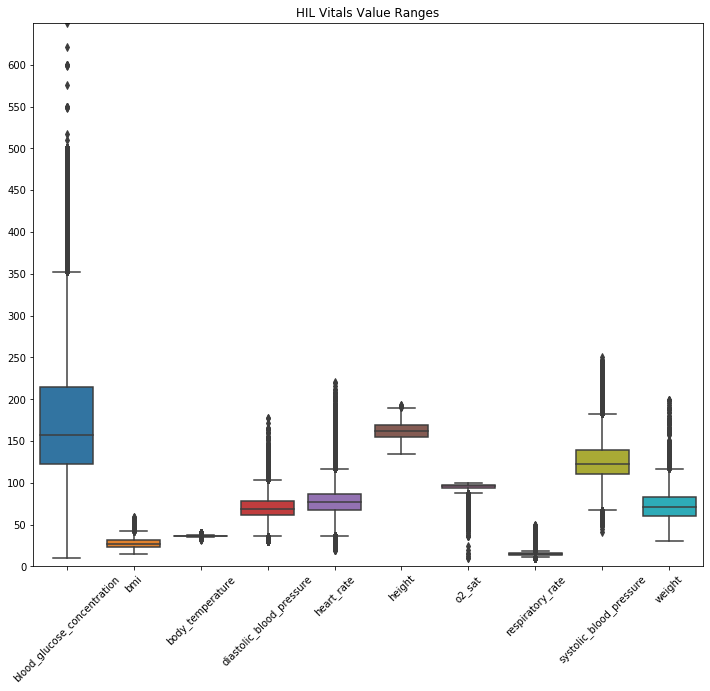

In [4]:
site_name = D_CONFIG['SITE_NAME']
vitals = parse_feature_cols(vitals_data_dict)
f_v, axs_v = plt.subplots(1,1, figsize=(12, 10))
sns.boxplot(data=vitals_df[vitals], ax=axs_v)
axs_v.tick_params(axis='x', rotation=45)
yticks = np.arange(0, 650, 50)
axs_v.set_yticks(yticks)
axs_v.set_ylim([0, 650])
axs_v.set_title(site_name + ' Vitals Value Ranges')
f_v.savefig('%s_vital_ranges'%site_name)
plt.show()


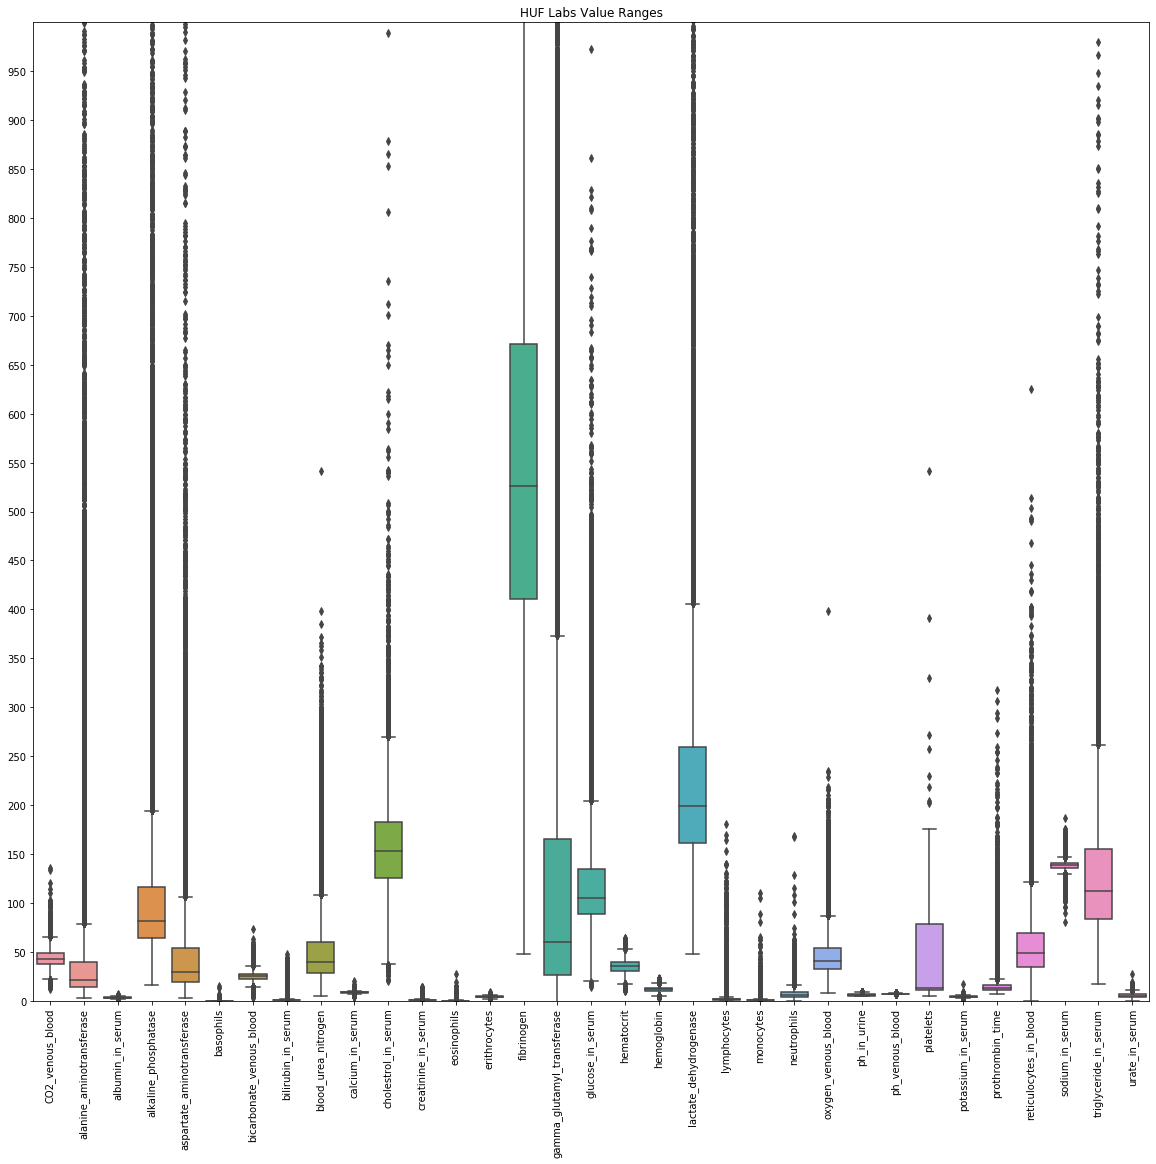

In [4]:
site_name = D_CONFIG['SITE_NAME']
labs = parse_feature_cols(labs_data_dict)
f_l, axs_l = plt.subplots(1,1, figsize=(20, 18))
sns.boxplot(data=labs_df[labs], ax=axs_l)
axs_l.tick_params(axis='x', rotation=90)
ymax=1000
yticks = np.arange(0, ymax, 50)
axs_l.set_yticks(yticks)
axs_l.set_ylim([0, ymax])
axs_l.set_title(D_CONFIG['SITE_NAME']+ ' Labs Value Ranges')
f_l.savefig('%s_lab_ranges'%site_name)
plt.show()

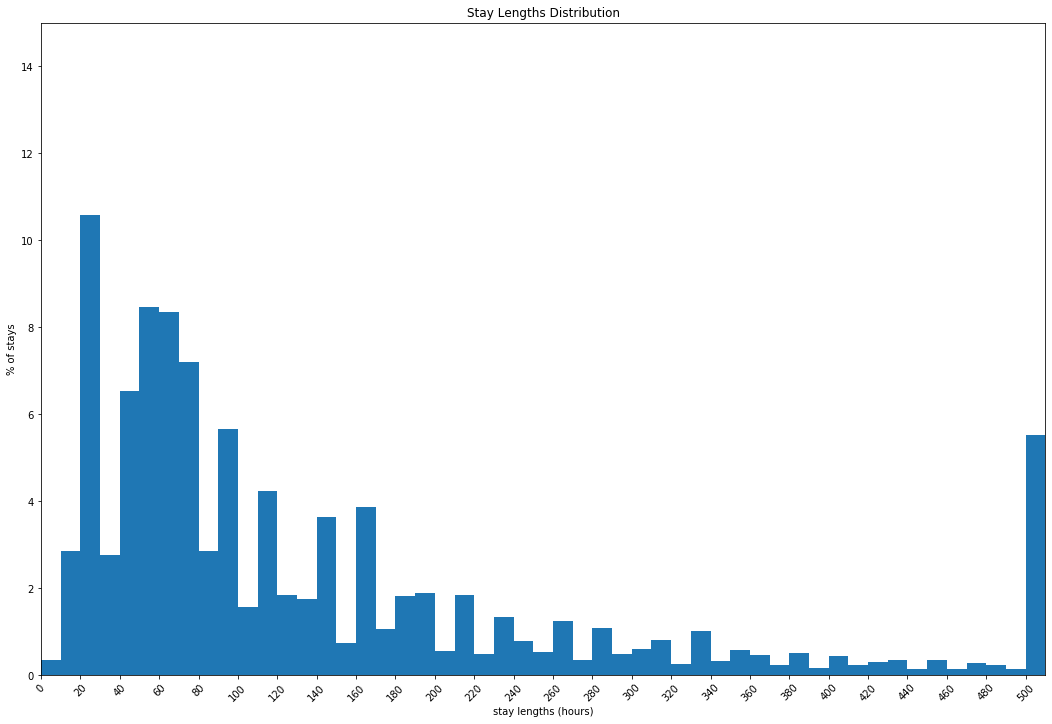

In [6]:
f,axs =  plt.subplots(1,1)
max_los = outcomes_df['stay_length'].max()
max_t = 500
step=10
bins = np.arange(0, max_t+1, step)
bins=np.insert(bins, len(bins), max_los)
x = outcomes_df['stay_length'].to_numpy()
plt.hist(x, bins=bins, weights=np.ones(len(x))*100 / len(x))
plt.xlabel('stay lengths (hours)')
plt.ylabel('% of stays')
plt.xlim([0, max_t+step])
bins[-1]=max_t
axs.set_xticks(bins[::2])
# x_ticks = np.arange(0, max_t+10, 24)
# axs.set_xticks(x_ticks)
axs.tick_params(axis='x', rotation=45)
#     axs.set_yticks(np.arange(0, 2500, 100))
axs.set_ylim([0, 15])
axs.set_title('Stay Lengths Distribution')
f.savefig('%s_stay_lengths.png'%site_name)
f.set_size_inches([18, 12])


In [12]:
# f,axs = plt.subplots(1,1,figsize=(10,8))
# plt.hist(np.asarray(outcomes_df['clinical_deterioration_outcome']), bins=2)
site_name = D_CONFIG['SITE_NAME']
num_pos = (outcomes_df['clinical_deterioration_outcome']==1).sum()
tot = len(outcomes_df)

print('Number of admissions in %s : %s'%(site_name, tot))
print('Number of clinical deteriorations in %s : %s'%(site_name, num_pos))
print('percentage clinical deteriorations in %s : %.4f %%'%(site_name, num_pos*100/tot))

Num admissions in HUF : 41731
Num clinical deteriorations in HUF : 599
percentage clinical deteriorations in HUF : 1.4354 %


In [5]:
site_name = D_CONFIG['SITE_NAME']
num_pos = (outcomes_df['clinical_deterioration_outcome']==1).sum()
tot = len(outcomes_df)

print('Number of admissions in %s : %s'%(site_name, tot))
print('Number of clinical deteriorations in %s : %s'%(site_name, num_pos))
print('percentage clinical deteriorations in %s : %.4f %%'%(site_name, num_pos*100/tot))

Number of admissions in HIL : 56525
Number of clinical deteriorations in HIL : 426
percentage clinical deteriorations in HIL : 0.7536 %


## Check why certain labs in HIL are missing

In [3]:
lab_csv_path = os.path.join('/rgi/data/HIL/deidentified_data', 'LABS.txt')
lookup_csv_path = os.path.join('/rgi/data/HIL/deidentified_data', 'LOINC_LOOKUP.txt')

# get the lab information
df_labs = pd.read_csv(lab_csv_path, delimiter='|', quotechar=None, quoting=3)

# get the loinc lookup file to get description of the lab test
df_loinc = pd.read_csv(lookup_csv_path, delimiter='|')

# remove duplicate loincs
df_loinc.drop_duplicates(subset=['LOINC'], keep='last', inplace=True)

# merge with labs csv to get lab descriptions based on LOINC
df_labs = pd.merge(df_labs, df_loinc, on='LOINC', how='inner')

In [27]:
df_labs[df_labs.LOINC=='14196-0']

,FACILITY_CD,PATIENT_ID,EVENT_TYPE,ID_ORDER,LOINC,VALUE_x,REF_MIN_VALUE,REF_MAX_VALUE,ABNORMAL_LOW,ABNORMAL_HIGH,UNIT,TS,VALUE_y,DESCRIPTION,CODING_STANDARD
23516482,2,2611560,1,28658684,14196-0,NaN,NaN,NaN,NaN,NaN,SIN UNIDAD,2023-04-15 09:39:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23516483,2,2611560,1,28658684,14196-0,40,30.0,90.0,NaN,NaN,SIN UNIDAD,2023-04-15 09:39:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23516484,2,2611560,1,23116658,14196-0,NaN,NaN,NaN,NaN,NaN,SIN UNIDAD,2023-06-03 08:50:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23516485,2,2611560,1,23116658,14196-0,46,30.0,90.0,NaN,NaN,SIN UNIDAD,2023-06-03 08:50:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23516486,2,243855,1,26091318,14196-0,NaN,NaN,NaN,NaN,NaN,SIN UNIDAD,2023-04-18 07:49:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23540193,2,2507344,2,27957022,14196-0,52,25.0,100.0,NaN,NaN,SIN UNIDAD,2026-01-22 01:16:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23540194,2,2530825,2,21564028,14196-0,NaN,NaN,NaN,NaN,NaN,SIN UNIDAD,2025-12-13 15:43:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23540195,2,2530825,2,21564028,14196-0,35.5,25.0,100.0,NaN,NaN,SIN UNIDAD,2025-12-13 15:43:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61
23540196,2,2981617,2,24098114,14196-0,NaN,NaN,NaN,NaN,NaN,SIN UNIDAD,2026-02-10 21:37:00,Reticulocitos/L 32,Reticulocytes [#/volume] in Blood,Version 2.61


## Get the admissions removed by exclusion criteria

In [2]:
sys.path.append('/home/prash/madrid-data-prep/demographics/')
from make_standard_demographics import filter_admissions_for_inclusion_criteria

In [3]:
df_adt = pd.read_csv(
        os.path.join('/rgi/data/HUF/deidentified_data', 'ADT.txt'),
        delimiter='|')
df_pd = pd.read_csv(
        os.path.join('/rgi/data/HUF/deidentified_data', 'PATIENT_DEMOGRAPHICS.txt'),
        delimiter='|')

df_demographics = filter_admissions_for_inclusion_criteria(df_adt, df_pd)

Total Hospital Admissions : 74635
Total neonatal hospital admissions : 2249


In [4]:
df_demographics.shape

(72380, 6)

In [5]:
df_adt_hadm = df_adt[df_adt.DESCRIPTION=='hospital_admission_ts'].copy()

print('Total Hospital Admissions : %s'%len(df_adt_hadm.ADMISSION_ID.unique()))

# get neo natal admissions
df_adt_neo = df_adt[df_adt.VALUE_TEXT=='NEO'].copy()

# remove neo natal admissions from non-ER admissions
non_neo_hadm_inds = ~(df_adt_hadm.ADMISSION_ID.isin(df_adt_neo.ADMISSION_ID.unique()))
print('Total neonatal hospital admissions : %s'%(~non_neo_hadm_inds).sum())

df_adt_hadm_non_neo = df_adt_hadm.loc[non_neo_hadm_inds,:].copy().reset_index(drop=True)

Total Hospital Admissions : 74635
Total neonatal hospital admissions : 2249


In [12]:
df_adt_hadm_non_neo.shape

(72386, 6)

In [13]:
74635-2249

72386

In [29]:
outcomes_df = pd.read_csv('/home/prash/datasets/v20200424/HUF/split-by=patient_id/collapsed_features_per_timeslice/classifier_train_test_split/outcomes.csv')


In [30]:
outcomes_df.columns

Index(['patient_id', 'hospital_admission_id', 'facility_code',
       'transfer_to_icu_timestamp', 'transfer_to_ICU_outcome',
       'inhospital_mortality_timestamp', 'inhospital_mortality_outcome',
       'clinical_deterioration_timestamp', 'clinical_deterioration_outcome',
       'stay_length'],
      dtype='object')

In [31]:
len(outcomes_df.hospital_admission_id.unique())

41731